# GR analyses

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from src.data_processing import mfp, process_test_set, hist_similarity, KL_divergence_prep, get_common_elements
from src.visualisations import plot_hist, val_eff_plots, stacked_barplot_MCCP_predictions, plot_coverage_analysis, KL_histograms
from src.scaffolds_generation import get_atomic_scaffold_and_smiles_counts, make_atomic_scaffold, smiles_counts
import pickle
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os
from PIL import Image

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, QED

from venny4py.venny4py import *
from molskill.scorer import MolSkillScorer


[2023-10-29 18:53:15,914] [INFO] [standardization.py:33:get_population_moments] Standardization moments not found. Downloading from remote...


## RFC-MCCP performance

In [3]:
# Process the RFC-MCCP test set results
df17_complete = process_test_set('M17_new', path = './results/', kfold = True)
df33_complete = process_test_set('M33_new', path = './results/', kfold = True)

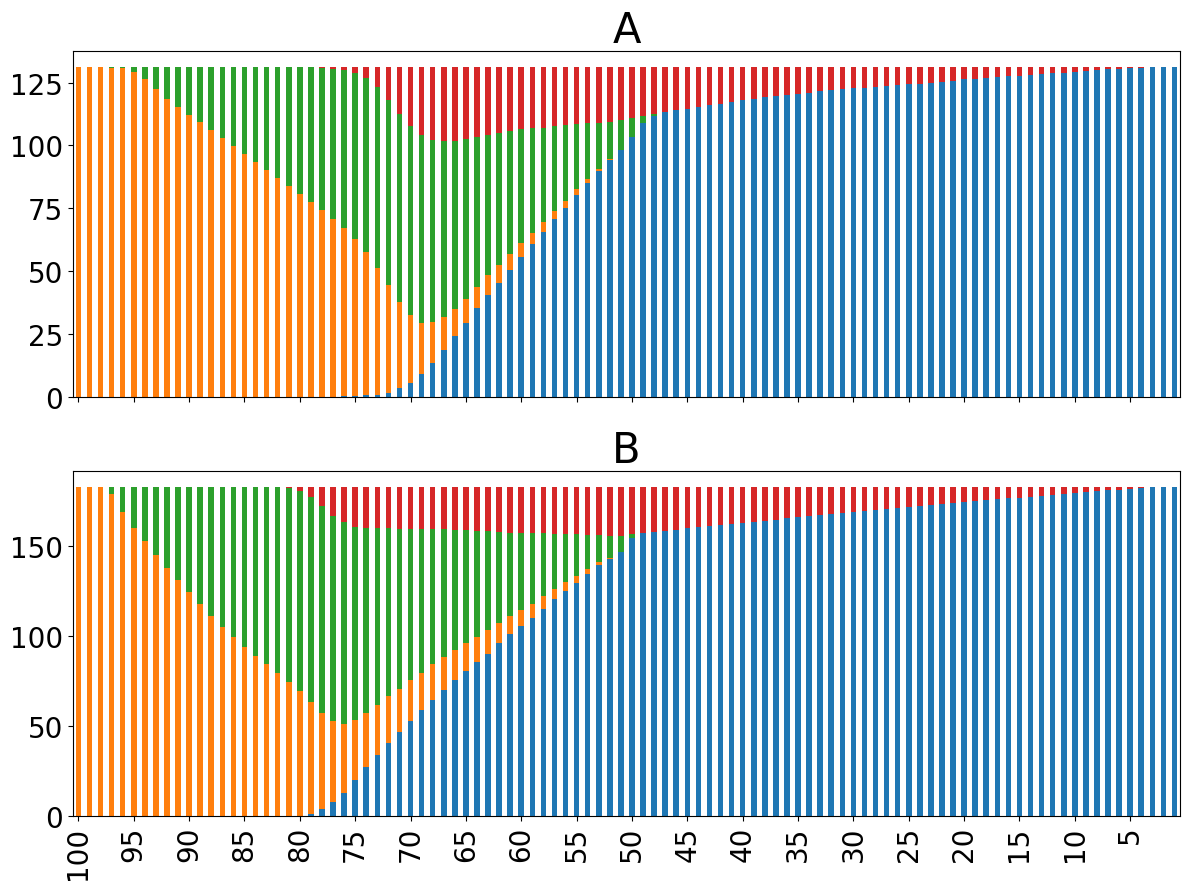

In [4]:
# Generate the barplot with the number of predictions for each model - (Paper Figure X )
stacked_barplot_MCCP_predictions(df17_complete, df33_complete)

90CL Model17: 99, average = 0.9696183206106871 and avg efficiency = 0.1129770992366412
90CL Model33: 92, average = 0.9224590163934425 and avg efficiency = 0.2407103825136612


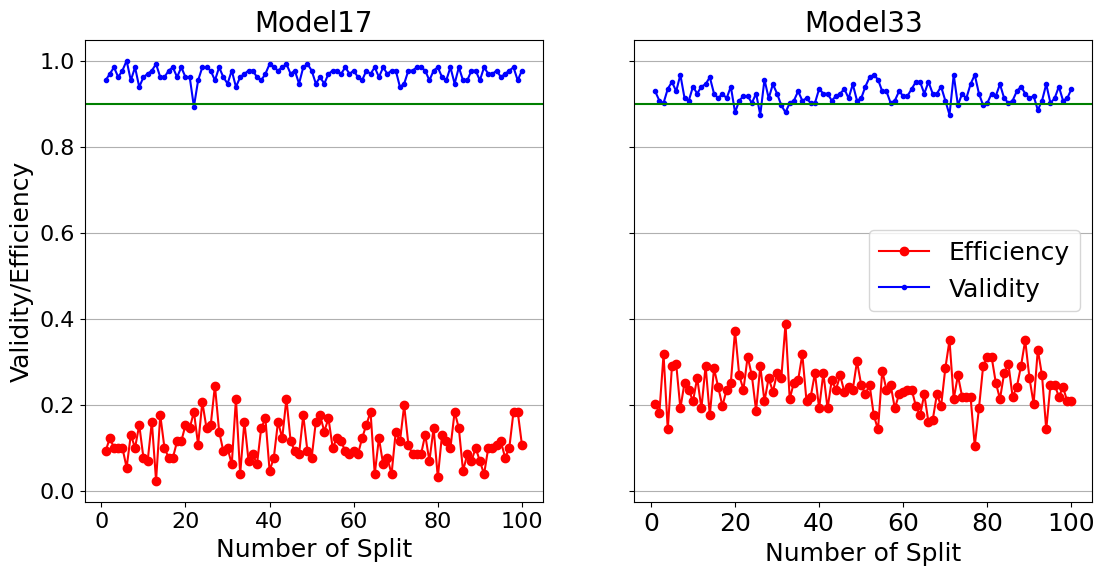

In [5]:
# Plot validity and efficiency - (Paper Figure X )
val_eff_plots(df17_complete, df33_complete)

## 1. Similarity analysis
### 1.1 Similarity of active predicted vs. ML inputs

In [6]:
# predicted by splits table % - GRML (Paper Table X )
for CL in ['90']:
    for ML in ['17', '33']:
        print(f"GRML CL {CL} and M{ML}:")
        GRML_Mx = pd.read_csv(f'./results/GRML_M{ML}_CL{CL}.csv', sep = ',')
        for i in range(0, 101, 10):
            print(f"Min number of runs: {i}")
            if i == 0:
                print(f"{len(GRML_Mx.loc[GRML_Mx['Active_count'] > i])*100/len(GRML_Mx)}% ({len(GRML_Mx.loc[GRML_Mx['Active_count'] > i])})")
            else:
                print(f"{len(GRML_Mx.loc[GRML_Mx['Active_count'] >= i])*100/len(GRML_Mx)}% ({len(GRML_Mx.loc[GRML_Mx['Active_count'] >= i])})")


GRML CL 90 and M17:
Min number of runs: 0
24.68851819041756% (246642)
Min number of runs: 10
4.29553109813166% (42913)
Min number of runs: 20
1.6973719113326626% (16957)
Min number of runs: 30
0.7929810863700745% (7922)
Min number of runs: 40
0.39218630350895634% (3918)
Min number of runs: 50
0.19349058822940596% (1933)
Min number of runs: 60
0.09399258269395354% (939)
Min number of runs: 70
0.038237664099137654% (382)
Min number of runs: 80
0.012712521834006497% (127)
Min number of runs: 90
0.002802760719308519% (28)
Min number of runs: 100
0.0% (0)
GRML CL 90 and M33:
Min number of runs: 0
43.27222313979269% (432296)
Min number of runs: 10
14.553435133606602% (145391)
Min number of runs: 20
8.291667292282899% (82835)
Min number of runs: 30
5.238259685790504% (52331)
Min number of runs: 40
3.4241728102180646% (34208)
Min number of runs: 50
2.232999504511944% (22308)
Min number of runs: 60
1.3964755283954695% (13951)
Min number of runs: 70
0.8302177644980305% (8294)
Min number of runs:

In [7]:
# predicted by splits table % - RML (Paper Table X )
for CL in ['90']:
    for ML in ['17', '33']:
        print(f"RML CL {CL} and M{ML}:")
        GRML_Mx = pd.read_csv(f'./results/RML_M{ML}_CL{CL}.csv', sep = ',')
        for i in range(0, 101, 10):
            print(f"Min number of runs: {i}")
            if i == 0:
                print(f"{len(GRML_Mx.loc[GRML_Mx['Active_count'] > i])*100/len(GRML_Mx)}% ({len(GRML_Mx.loc[GRML_Mx['Active_count'] > i])})")
            else:
                print(f"{len(GRML_Mx.loc[GRML_Mx['Active_count'] >= i])*100/len(GRML_Mx)}% ({len(GRML_Mx.loc[GRML_Mx['Active_count'] >= i])})")


RML CL 90 and M17:
Min number of runs: 0
10.192006298697923% (137216)
Min number of runs: 10
0.7543582087335012% (10156)
Min number of runs: 20
0.2100556335465086% (2828)
Min number of runs: 30
0.07925366371786587% (1067)
Min number of runs: 40
0.03260764608448277% (439)
Min number of runs: 50
0.013147046371192371% (177)
Min number of runs: 60
0.006462107538382691% (87)
Min number of runs: 70
0.0020797587479852338% (28)
Min number of runs: 80
0.0005199396869963084% (7)
Min number of runs: 90
7.427709814232977e-05% (1)
Min number of runs: 100
0.0% (0)
RML CL 90 and M33:
Min number of runs: 0
24.493838714709092% (329763)
Min number of runs: 10
4.593444303317958% (61842)
Min number of runs: 20
2.034301163922128% (27388)
Min number of runs: 30
1.0711500323105376% (14421)
Min number of runs: 40
0.5902058218389524% (7946)
Min number of runs: 50
0.320060015895299% (4309)
Min number of runs: 60
0.17031738604036217% (2293)
Min number of runs: 70
0.08036782019000081% (1082)
Min number of runs: 8

In [8]:
# TODO remove IMG structures from the input set
data_input_GRML = pd.read_csv('./data/pd_input_morphs.csv',sep='\t').drop_duplicates()
data_input_RML = pd.read_csv('./data/pd_input_ran_morphs.csv',sep='\t').drop_duplicates()

GRML_M33 = pd.read_csv(f'./results/GRML_M33_CL90.csv', sep = ',')
GRML_M17 = pd.read_csv(f'./results/GRML_M17_CL90.csv', sep = ',')

GRML_actives_M17 = GRML_M17.loc[GRML_M17['Active_count'] >= 50]
GRML_actives_M33 = GRML_M33.loc[GRML_M33['Active_count'] >= 50]

RML_M33 = pd.read_csv(f'./results/RML_M33_CL90.csv', sep = ',')
RML_M17 = pd.read_csv(f'./results/RML_M17_CL90.csv', sep = ',')

RML_actives_M17 = RML_M17.loc[RML_M17['Active_count'] >= 50]
RML_actives_M33 = RML_M33.loc[RML_M33['Active_count'] >= 50]

# Join GRML active predicted by both models and same with RML
GRML_active = pd.concat([GRML_actives_M17[['id_morph', 'morph_smiles']], GRML_actives_M33[['id_morph', 'morph_smiles']]]).drop_duplicates()
RML_active = pd.concat([RML_actives_M17[['id_morph', 'morph_smiles']], RML_actives_M33[['id_morph', 'morph_smiles']]]).drop_duplicates()
len(GRML_active), len(RML_active), len(GRML_actives_M17), len(GRML_actives_M33), len(RML_actives_M17), len(RML_actives_M33)

(22527, 4341, 1933, 22308, 177, 4309)

Low similarity 1318
Medium similarity 598
High similarity 17
Identical: 2
Mean Tc: 0.36443056275669583
Median Tc: 0.3492063492063492
Mode Tc: ModeResult(mode=0.3333333333333333, count=54)
Low similarity 17044
Medium similarity 5179
High similarity 85
Identical: 6
Mean Tc: 0.33616045574608067
Median Tc: 0.3148148148148148
Mode Tc: ModeResult(mode=0.3333333333333333, count=507)
Low similarity 149
Medium similarity 27
High similarity 1
Identical: 0
Mean Tc: 0.33202728071634297
Median Tc: 0.32558139534883723
Mode Tc: ModeResult(mode=0.3333333333333333, count=10)
Low similarity 4095
Medium similarity 212
High similarity 2
Identical: 0
Mean Tc: 0.28308095338010336
Median Tc: 0.27450980392156865
Mode Tc: ModeResult(mode=0.3333333333333333, count=102)
Low similarity 1834
Medium similarity 99
High similarity 0
Identical: 0
Mean Tc: 0.27430658847563294
Median Tc: 0.2653061224489796
Mode Tc: ModeResult(mode=0.25, count=52)
Low similarity 21788
Medium similarity 517
High similarity 3
Identical: 0


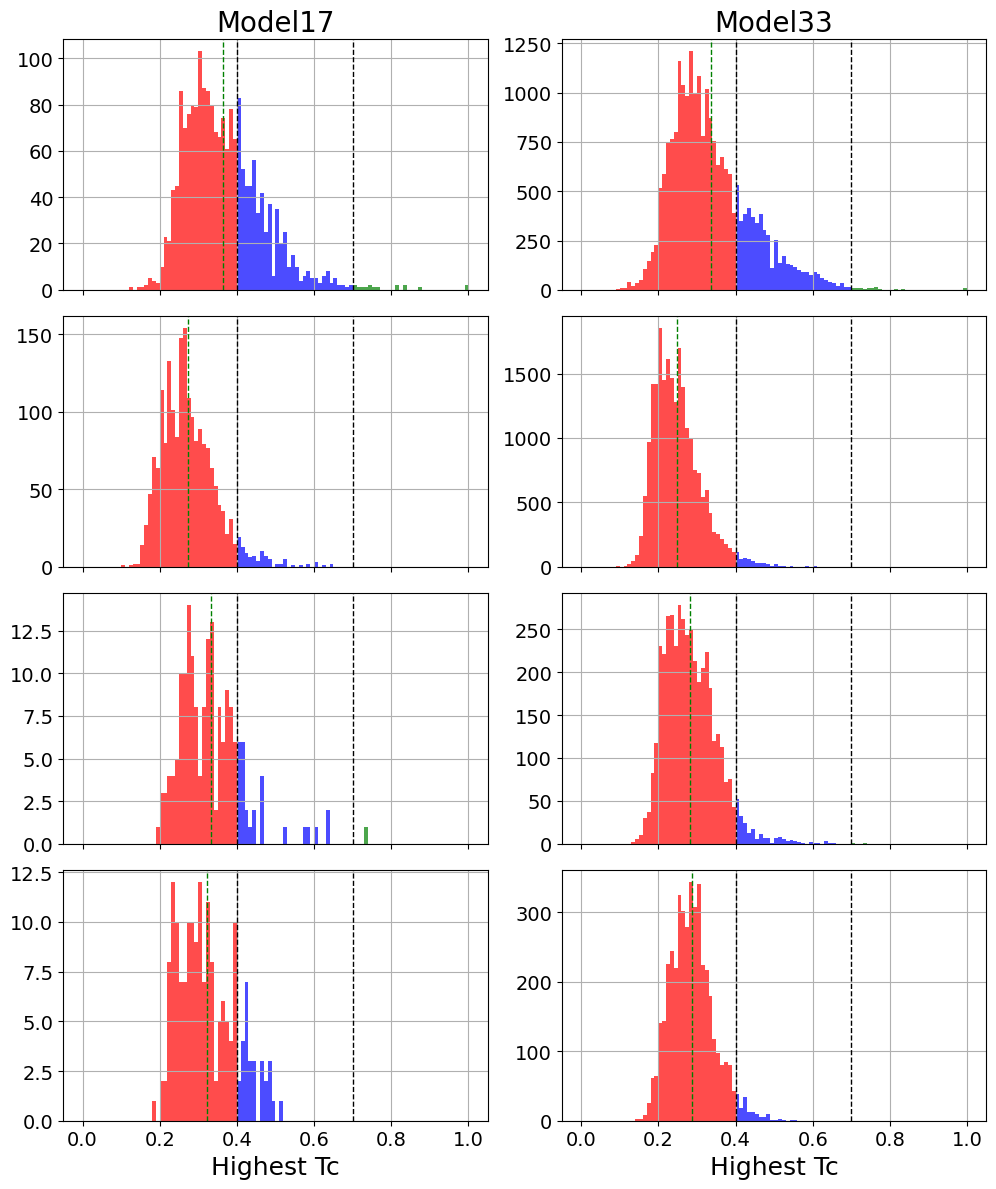

In [9]:
# (Paper Figure X )
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True)

# Create histograms in each subplot
id_GRML_M17, id_ch_GRML_M17, high_TC_GRML_M17, avg_TC_GRML_M17 = hist_similarity(data_input_GRML, GRML_actives_M17) #
plot_hist(ax[0, 0], high_TC_GRML_M17)
id_GRML_M33, id_ch_GRML_M33, high_TC_GRML_M33, avg_TC_GRML_M33 = hist_similarity(data_input_GRML, GRML_actives_M33) #
plot_hist(ax[0, 1], high_TC_GRML_M33)
_, _, high_TC_GRML_RM17, _ = hist_similarity(data_input_GRML, RML_actives_M17, RML_data = True, RML_input = False) #
plot_hist(ax[2, 0], high_TC_GRML_RM17)
_, _, high_TC_GRML_RM33, _ = hist_similarity(data_input_GRML, RML_actives_M33, RML_data = True, RML_input = False) #
plot_hist(ax[2, 1], high_TC_GRML_RM33)
_, _, high_TC_RML_M17, _ = hist_similarity(data_input_RML, GRML_actives_M17, RML_data = False, RML_input = True) #
plot_hist(ax[1, 0], high_TC_RML_M17)
_, _, high_TC_RML_M33, _ = hist_similarity(data_input_RML, GRML_actives_M33, RML_data = False, RML_input = True) #
plot_hist(ax[1, 1], high_TC_RML_M33)
_, _, high_TC_RML_RM17, _ = hist_similarity(data_input_RML, RML_actives_M17, RML_input = True, RML_data = True) #
plot_hist(ax[3, 0], high_TC_RML_RM17, end_plot = True)
_, _, high_TC_RML_RM33, _ = hist_similarity(data_input_RML, RML_actives_M33, RML_input = True, RML_data = True) #
plot_hist(ax[3, 1], high_TC_RML_RM33, end_plot = True)

ax[0, 0].set_title('Model17', fontsize=20)
ax[0, 1].set_title('Model33', fontsize=20)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

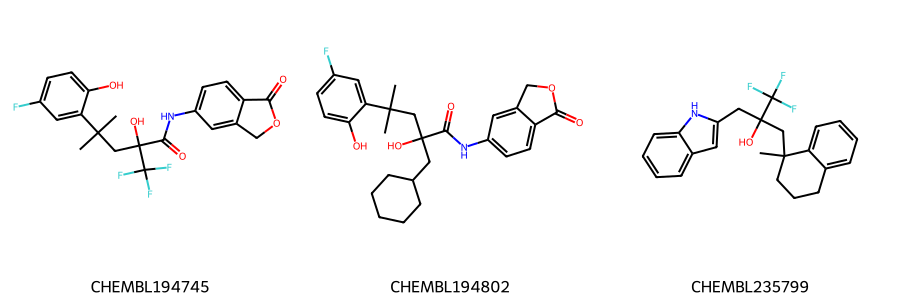

In [10]:
# Join the input ids, select the unique ids and plot the image
input_ids = list(set(id_ch_GRML_M33 + id_ch_GRML_M17))
rediscovered = data_input_GRML.loc[data_input_GRML['id_in_source'].isin(input_ids)]
rediscovered = rediscovered.loc[rediscovered['source'] != 'gr_hts_umg']

data_ch33 = pd.read_csv('./data/GR_model33_training.csv', sep=',')
source = []
for molregno in rediscovered.id_in_source.tolist():
    source.append(data_ch33.loc[data_ch33['molregno'] == molregno].chembl_id.values[0])

smiles = rediscovered.smiles.tolist()
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smiles],
                     legends = source, 
                     subImgSize=(300, 300))

### 1.2 - Coverage analysis

In [11]:
# Get known data for M33 and M17
data_ch33 = pd.read_csv('./data/GR_model33_training.csv', sep=',')
data_ch17 = data_ch33.loc[data_ch33['chembl_version'] != 'ChEMBL33']
novel_data = data_ch33.loc[data_ch33['chembl_version'] == 'ChEMBL33']
novel_ids = novel_data.chembl_id.tolist()

# Get FPS for available data when ChEMBL17
known_smiles = data_ch17.canonical_smiles.tolist()
known_smiles_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2,nBits=1024) for x in known_smiles]

# Get FPS for novel data
novel_smiles = novel_data.canonical_smiles.tolist()
novel_smiles_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2,nBits=1024) for x in novel_smiles]

# Get the novel set subsets
fil_ch28 = []
for thr in [(0, 0.4), (0.4, 0.7), (0.7, 1)]:
    print(f'For thr: {thr}')
    highest_TC, avg_TC= [], []
    below_07 = []
    for i, fps in enumerate(novel_smiles_fps):
        tc = 0
        for x, fps_inp in enumerate(known_smiles_fps):
            tca = DataStructs.FingerprintSimilarity(fps, fps_inp)
            if tca > tc:
                tc = tca
        highest_TC.append(tc)
        if tc <= thr[1] and tc > thr[0]:
            below_07.append(novel_ids[i])
        tc=0
    print(f"There are {len(below_07)} novel compounds")
    fil_ch28.append(novel_data.loc[novel_data['chembl_id'].isin(below_07)])

For thr: (0, 0.4)
There are 97 novel compounds
For thr: (0.4, 0.7)
There are 127 novel compounds
For thr: (0.7, 1)
There are 28 novel compounds


Low similarity
Low similarity 1933
Medium similarity 0
High similarity 0
Identical: 0
Mean Tc: 0.1808598256957255
Median Tc: 0.17857142857142858
Mode Tc: ModeResult(mode=0.2, count=38)
Low similarity 22274
Medium similarity 34
High similarity 0
Identical: 0
Mean Tc: 0.17950590288194965
Median Tc: 0.17333333333333334
Mode Tc: ModeResult(mode=0.16666666666666666, count=416)
Medium similarity
Low similarity 1919
Medium similarity 14
High similarity 0
Identical: 0
Mean Tc: 0.1834327064207444
Median Tc: 0.1774193548387097
Mode Tc: ModeResult(mode=0.16666666666666666, count=53)
Low similarity 21500
Medium similarity 808
High similarity 0
Identical: 0
Mean Tc: 0.19662955836454915
Median Tc: 0.17857142857142858
Mode Tc: ModeResult(mode=0.16666666666666666, count=542)
High similarity
Low similarity 1927
Medium similarity 6
High similarity 0
Identical: 0
Mean Tc: 0.1584514585348512
Median Tc: 0.1527777777777778
Mode Tc: ModeResult(mode=0.14285714285714285, count=52)
Low similarity 21931
Medium s

/storage/plzen1/home/agealorm/miniconda/envs/GRML_analyses/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[]

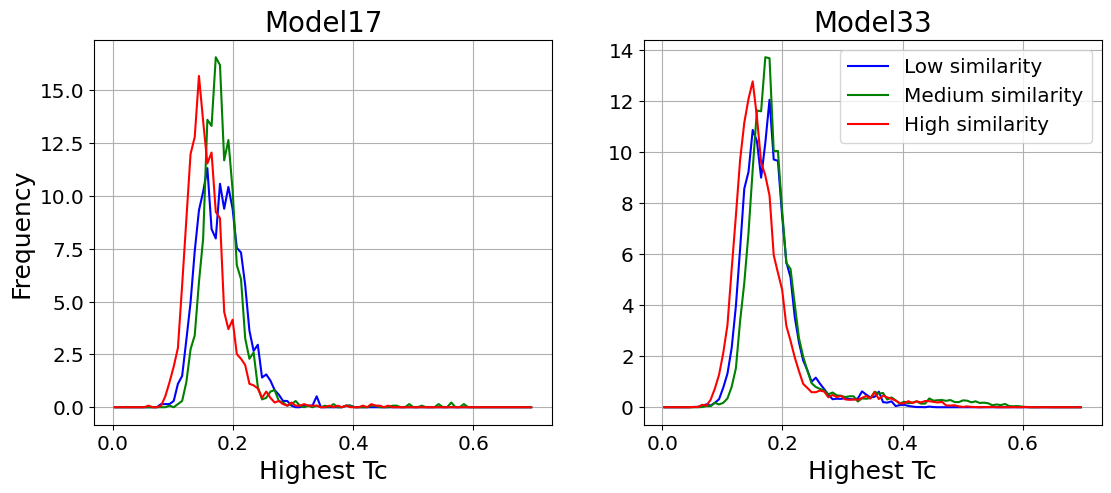

In [12]:
# Plot the distribution of the Novel set subsets vs. GRML actives from Model 17 and Model33
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharex=True)

# Low
print("Low similarity")
_, _, high_TC_novel_M17_low, _= hist_similarity(fil_ch28[0], GRML_actives_M17, RML_input = False, novel = True)
_, _, high_TC_novel_M33_low, _= hist_similarity(fil_ch28[0], GRML_actives_M33, RML_input = False, novel = True)
# Medium
print("Medium similarity")
_, _, high_TC_novel_M17_medium, _= hist_similarity(fil_ch28[1], GRML_actives_M17, RML_input = False, novel = True)
_, _, high_TC_novel_M33_medium, _= hist_similarity(fil_ch28[1], GRML_actives_M33, RML_input = False, novel = True)
# High
print("High similarity")
_, _, high_TC_novel_M17_high, _= hist_similarity(fil_ch28[2], GRML_actives_M17, RML_input = False, novel = True)
_, _, high_TC_novel_M33_high, _= hist_similarity(fil_ch28[2], GRML_actives_M33, RML_input = False, novel = True)
plot_coverage_analysis(ax[0], high_TC_novel_M17_low, high_TC_novel_M17_medium, high_TC_novel_M17_high, "Model17", y_label = True)
plot_coverage_analysis(ax[1], high_TC_novel_M33_low, high_TC_novel_M33_medium, high_TC_novel_M33_high, "Model33", legend = True)
plt.plot()


### 1.3 - KL divergence of distribution between Novel Set vs. GRML/RML - Run on metacentrum

In [13]:
# GRML
GRML_filtered = pd.read_csv('./data/pd_morphs.csv',sep=',')

# RML
RML_filtered = pd.read_csv('./data/pd_ran_morphs.csv', sep = ',')

In [14]:
# Get the highest Tanimoto between morphing library and novel set
high_TC_novel_GRML_1 = KL_divergence_prep(novel_data, GRML_filtered, 'canonical_smiles', 'morph_smiles')
high_TC_novel_RML_1 = KL_divergence_prep(novel_data, RML_filtered, 'canonical_smiles', 'morph_smiles')

# Create histograms (probability distributions)
hist1, bin_edges = np.histogram(high_TC_novel_GRML_1, bins=100, range=(0, 1), density=True)
hist2, _ = np.histogram(high_TC_novel_RML_1, bins=100, range=(0, 1), density=True)

# Apply Laplace smoothing
smoothed_hist1 = (hist1 + 1e-10) / np.sum(hist1 + 1e-10)
smoothed_hist2 = (hist2 + 1e-10) / np.sum(hist2 + 1e-10)

# Compute KL divergence
kl_divergence = entropy(smoothed_hist1, smoothed_hist2)

print("KL Divergence:", kl_divergence)

KL Divergence: 14.479743922759196


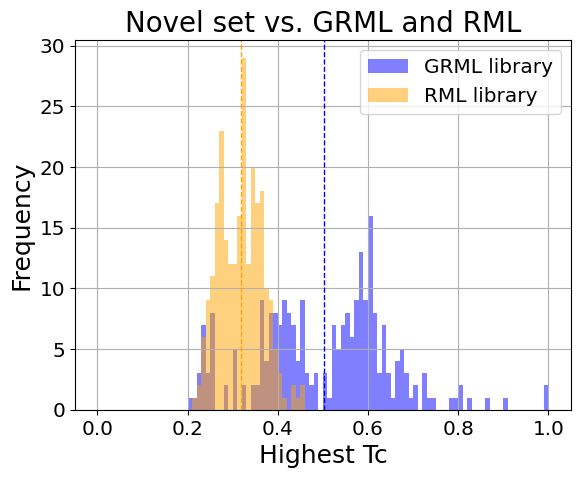

In [15]:
# Plot the histograms
KL_histograms(high_TC_novel_GRML_1, high_TC_novel_RML_1)


## 2. Scaffold analysis
### 2.1 Venn diagrams comparing GRML, RML, active GRML and active RML - On Metacentrum

In [16]:
# get the scaffolds
_, GRML_active_agg_sca = get_atomic_scaffold_and_smiles_counts(GRML_active, 'morph_smiles')
_, RML_active_agg_sca = get_atomic_scaffold_and_smiles_counts(RML_active, 'morph_smiles')
#_, GRML_agg_sca = get_atomic_scaffold_and_smiles_counts(GRML_filtered, 'morph_smiles')
#_, RML_agg_sca = get_atomic_scaffold_and_smiles_counts(RML_filtered, 'morph_smiles')

GRML_active_sca = [item[0] for item in GRML_active_agg_sca]
RML_active_sca = [item[0] for item in RML_active_agg_sca]
#GRML_sca = [item[0] for item in GRML_agg_sca]
#RML_sca = [item[0] for item in RML_agg_sca]

In [17]:
"""# ML vs. active predicted
sets = {
    'GR actives': set(GRML_active_sca),
    'Random actives': set(RML_active_sca),
    'GRML': set(GRML_sca),
    'RML': set(RML_sca)}
    
venny4py(sets=sets, size=10, dpi=900, asax = False, out = f"{os.getcwd()}/results/", ext='png')
# the output filename is hardcoded, change the name once generated, same for the intersections file
cmd = f"mv {os.getcwd()}/results/Venn_4.png {os.getcwd()}/results/venn_ML_actives_ML.png" 
os.system(cmd)
cmd = f"mv {os.getcwd()}/results/Intersections_4.txt {os.getcwd()}/results/intersections_ML_actives_ML.txt" 
os.system(cmd)
im = Image.open(f"{os.getcwd()}/results/venn_ML_actives_ML.png") 
 
im.show()"""

'# ML vs. active predicted\nsets = {\n    \'GR actives\': set(GRML_active_sca),\n    \'Random actives\': set(RML_active_sca),\n    \'GRML\': set(GRML_sca),\n    \'RML\': set(RML_sca)}\n    \nvenny4py(sets=sets, size=10, dpi=900, asax = False, out = f"{os.getcwd()}/results/", ext=\'png\')\n# the output filename is hardcoded, change the name once generated, same for the intersections file\ncmd = f"mv {os.getcwd()}/results/Venn_4.png {os.getcwd()}/results/venn_ML_actives_ML.png" \nos.system(cmd)\ncmd = f"mv {os.getcwd()}/results/Intersections_4.txt {os.getcwd()}/results/intersections_ML_actives_ML.txt" \nos.system(cmd)\nim = Image.open(f"{os.getcwd()}/results/venn_ML_actives_ML.png") \n \nim.show()'

### 2.2 Venn diagrams comparing GRML, RML, GRML input and RML input

In [18]:
# Get the smiles and the atomic scaffold from the GRML input
GRML_input_atomic_scaffolds, GRML_input_agg_atomic_scaffolds = get_atomic_scaffold_and_smiles_counts(data_input_GRML, 'smiles')

# Same for the model's inputs inputs
ML17_input=pd.read_csv('./data/GR_model17_training.csv', sep=',')
ML33_input=pd.read_csv('./data/GR_model33_training.csv', sep=',')

ML17_input_atomic_scaffolds, ML17_input_agg_atomic_scaffolds = get_atomic_scaffold_and_smiles_counts(ML17_input, 'canonical_smiles')
ML33_input_atomic_scaffolds, ML33_input_agg_atomic_scaffolds = get_atomic_scaffold_and_smiles_counts(ML33_input, 'canonical_smiles')

# Join the scaffolds from the ML input and the GRML input
data_all_atomic_scaffolds_M17 = ML17_input_atomic_scaffolds+GRML_input_atomic_scaffolds
data_all_atomic_scaffolds_M33 = ML33_input_atomic_scaffolds+GRML_input_atomic_scaffolds

data_all_agg_atomic_scaffolds_M17 = smiles_counts((Chem.MolToSmiles(s) for s in data_all_atomic_scaffolds_M17 if s))
data_all_agg_atomic_scaffolds_M33 = smiles_counts((Chem.MolToSmiles(s) for s in data_all_atomic_scaffolds_M33 if s))

all_sca_smiles_M17 = [x[0] for x in data_all_agg_atomic_scaffolds_M17]
all_sca_smiles_M33 = [x[0] for x in data_all_agg_atomic_scaffolds_M33]

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


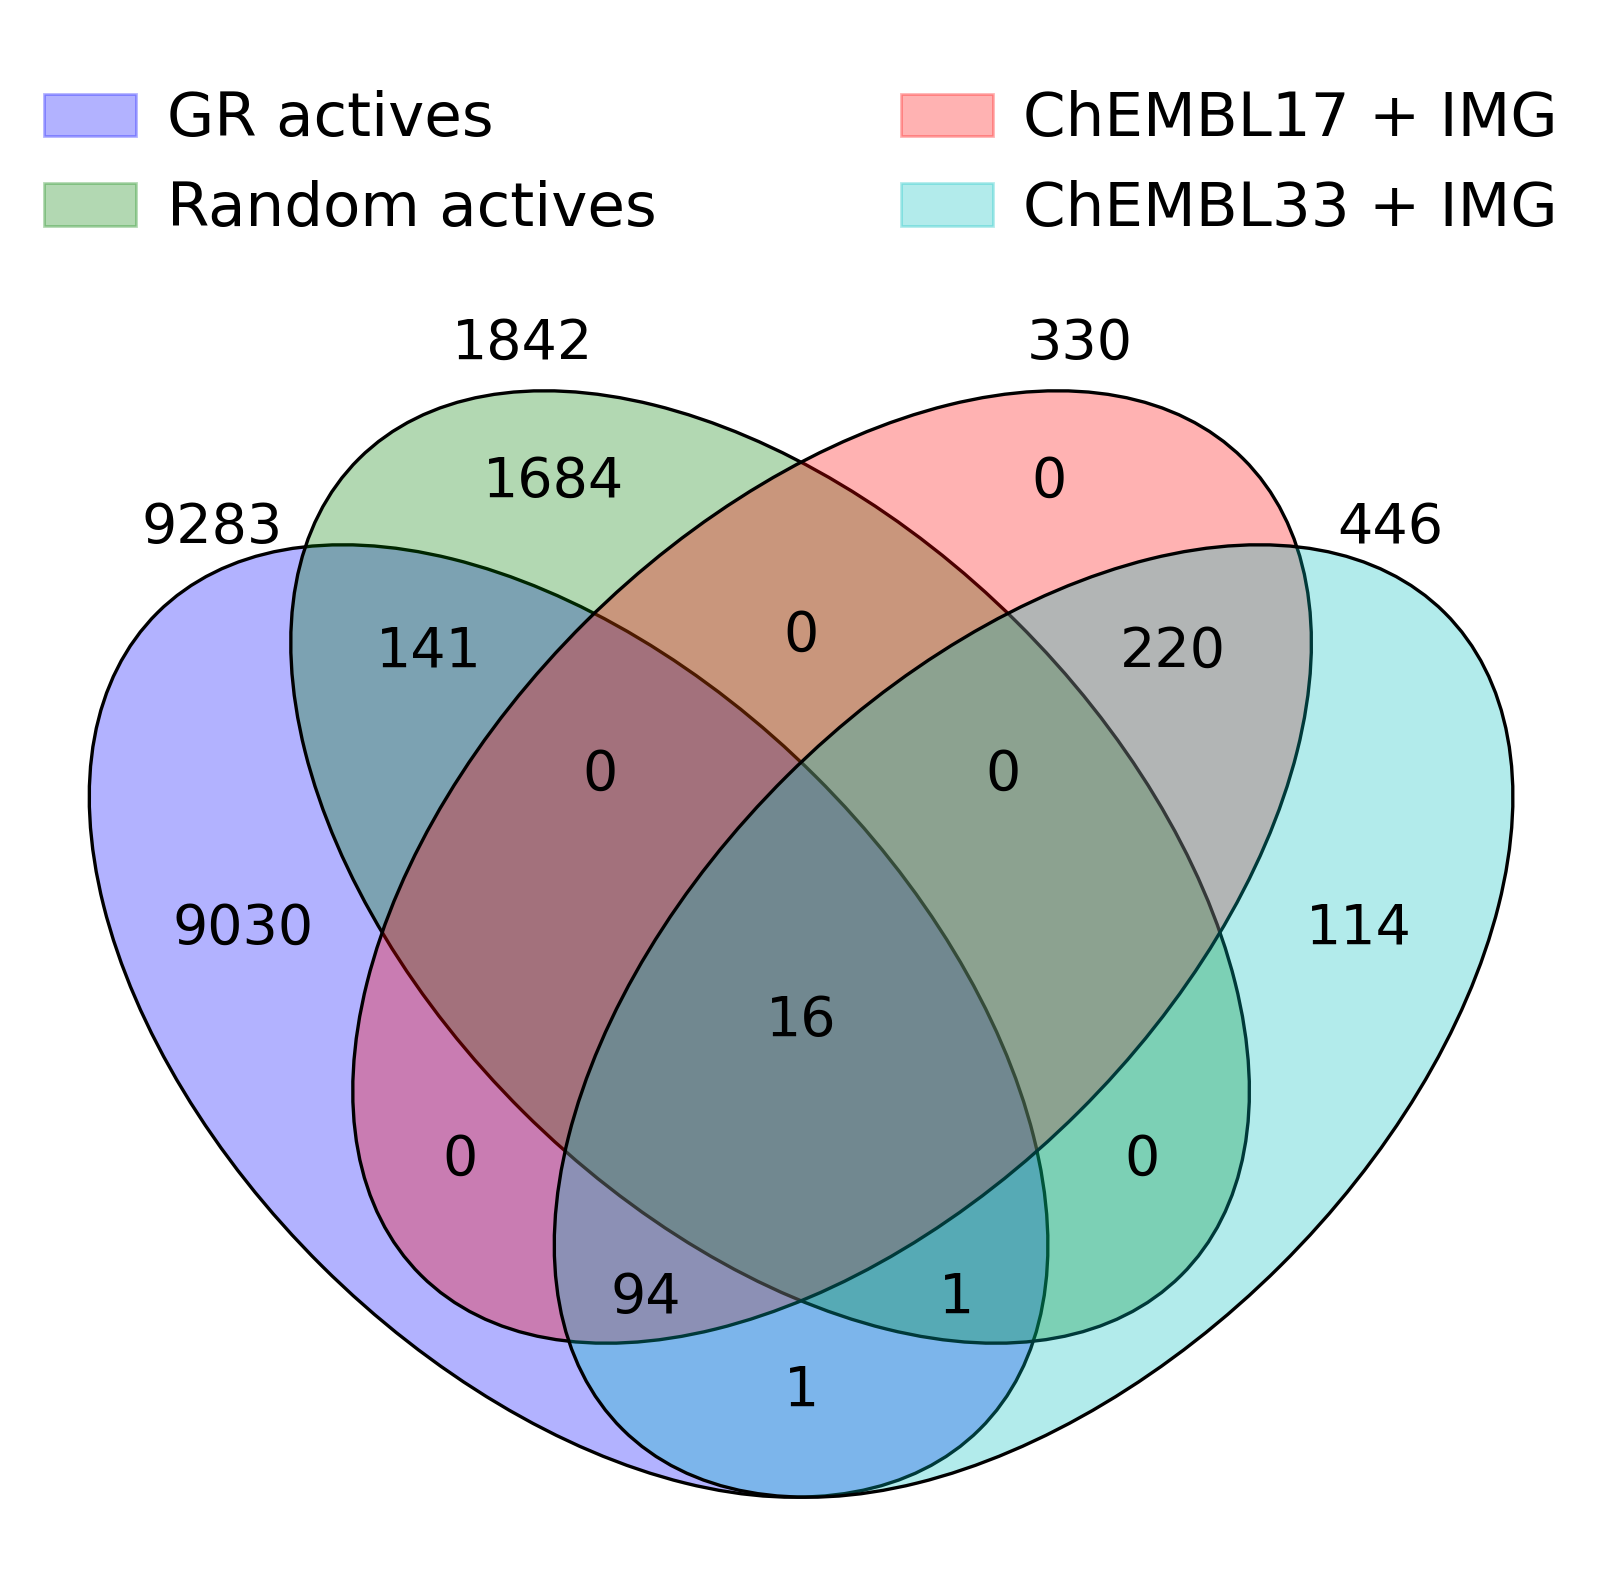

In [19]:
# actives vs. inputs
sets = {
    'GR actives': set(GRML_active_sca),
    'Random actives': set(RML_active_sca),
    'ChEMBL17 + IMG': set(all_sca_smiles_M17),
    'ChEMBL33 + IMG': set(all_sca_smiles_M33)}
    
venny4py(sets=sets, size=10, dpi=900, asax = False, out=f'{os.getcwd()}/results/', ext='png')
cmd = f"mv {os.getcwd()}/results/Venn_4.png {os.getcwd()}/results/venn_ML_actives_inputs.png" 
os.system(cmd)
cmd = f"mv {os.getcwd()}/results/Intersections_4.txt {os.getcwd()}/results/intersections_ML_actives_inputs.txt" 
os.system(cmd)
im = Image.open(f"{os.getcwd()}/results/venn_ML_actives_inputs.png") 

cmd = f"cp {os.getcwd()}/results/intersections_ML_actives_inputs.txt /storage/plzen1/home/agealorm/RFC-MCCP/GRML_analyses/results/intersections_ML_actives_inputs.txt" 
os.system(cmd)
cmd = f"cp {os.getcwd()}/results/venn_ML_actives_inputs.png /storage/plzen1/home/agealorm/RFC-MCCP/GRML_analyses/results/venn_ML_actives_inputs.png" 
os.system(cmd)
 
im.show()

### 2.2 Scaffold examples

In [20]:

# Training data scaffolds
_, input_M17_agg_scaffolds = get_atomic_scaffold_and_smiles_counts(data_ch17, 'canonical_smiles')
_, input_M33_agg_scaffolds = get_atomic_scaffold_and_smiles_counts(data_ch33, 'canonical_smiles')

M17_known_scaffolds = [sca[0] for sca in input_M17_agg_scaffolds]
M33_known_scaffolds = [sca[0] for sca in input_M33_agg_scaffolds]

_, GRML_M17_agg_scaffolds = get_atomic_scaffold_and_smiles_counts(GRML_actives_M17, 'morph_smiles')
_, GRML_M33_agg_scaffolds = get_atomic_scaffold_and_smiles_counts(GRML_actives_M33, 'morph_smiles')
_, RML_M17_agg_scaffolds = get_atomic_scaffold_and_smiles_counts(RML_actives_M17, 'morph_smiles')
_, RML_M33_agg_scaffolds = get_atomic_scaffold_and_smiles_counts(RML_actives_M33, 'morph_smiles')

# select top 3 active scaffolds by M17 and M33 for GRML and RML
top_3 = []
for scas in [GRML_M17_agg_scaffolds, GRML_M33_agg_scaffolds, RML_M17_agg_scaffolds, RML_M33_agg_scaffolds]:
    for i in range(3):
        top_3.append(scas[i])

# select top 3 active scaffolds by M17 and M33 for GRML and RML unknown by their inputs
top_3_unk = []
count = 0
for i, scas in enumerate([GRML_M17_agg_scaffolds, GRML_M33_agg_scaffolds, RML_M17_agg_scaffolds, RML_M33_agg_scaffolds]):
    if i in [0, 2]:
        for sca in scas:
            if count < 3 and sca[0] not in M17_known_scaffolds:
                top_3_unk.append(sca)
                count += 1
        count = 0
    elif i in [1, 3]:
        for sca in scas:
            if count < 3 and sca[0] not in M33_known_scaffolds:
                top_3_unk.append(sca)
                count += 1
        count = 0

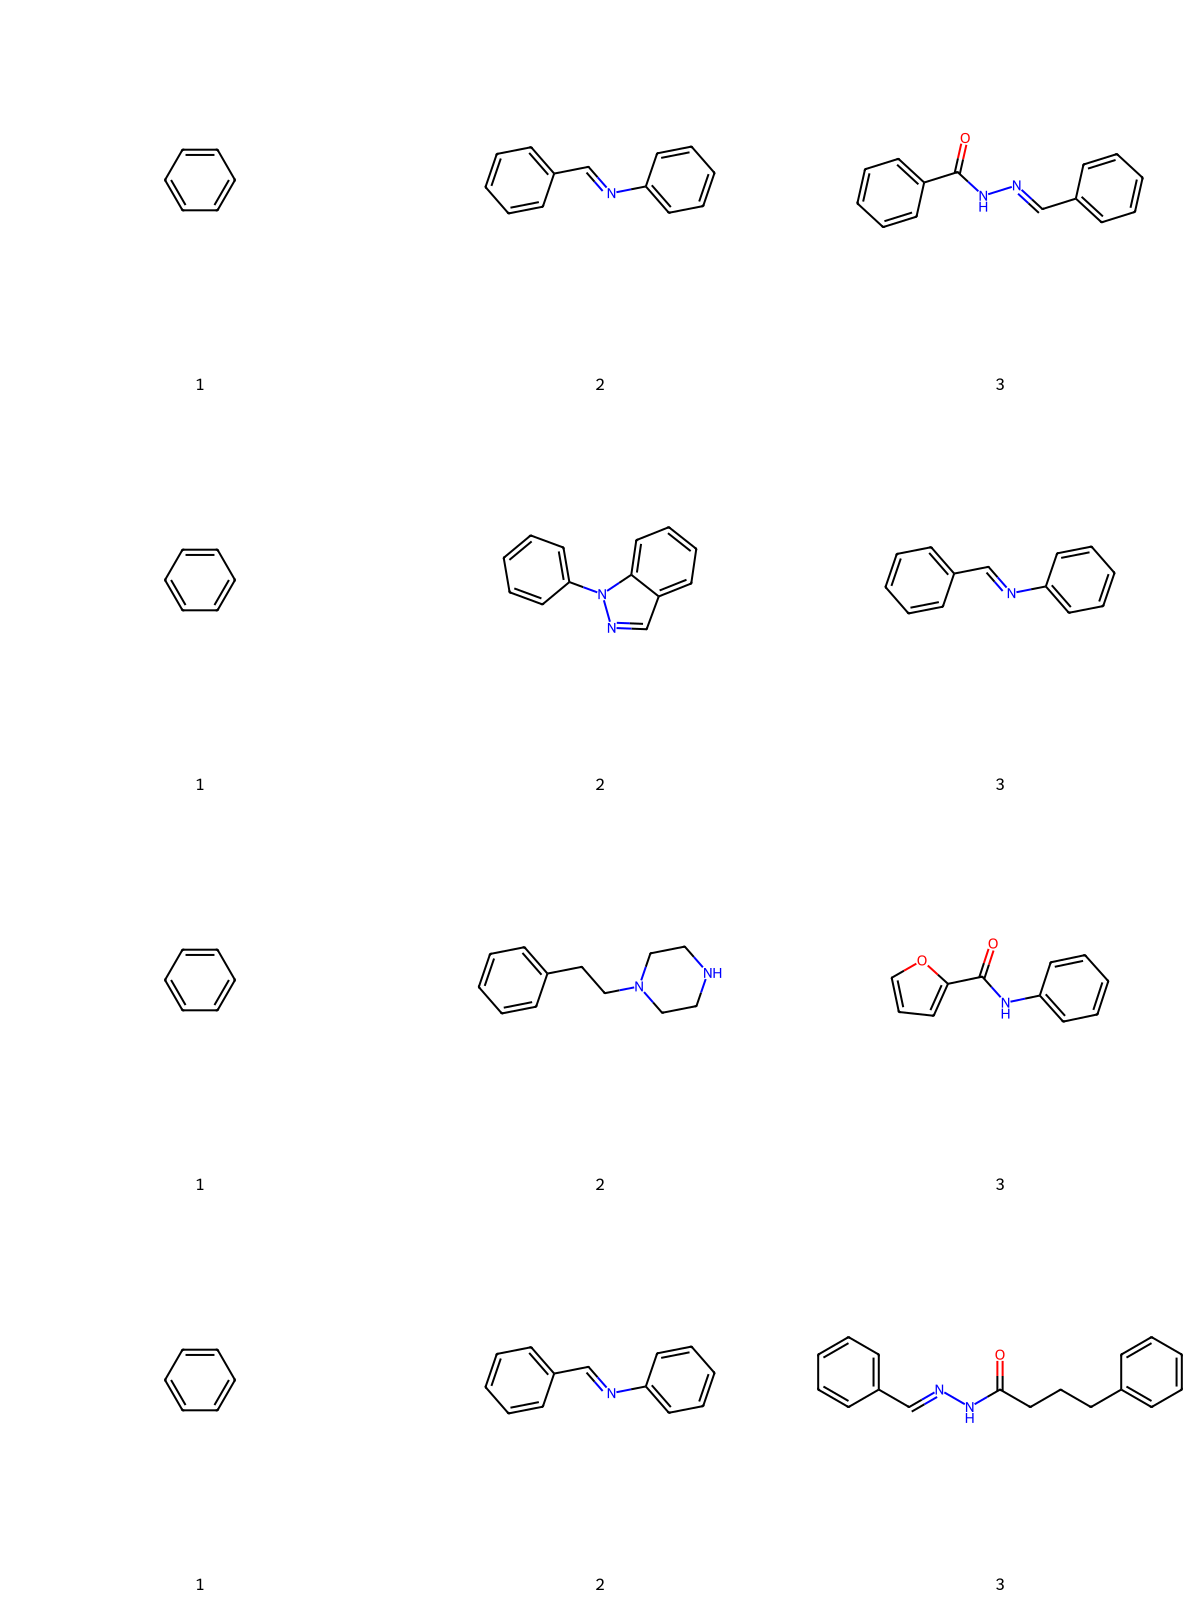

In [21]:
# Plot top 3 recurrent scaffolds for active predicted morphs: GRML-M17, GRML-M33, RML-M17, RML-M33
num=12
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in list(top_3[i] for i in list(range(num)))],
                     legends=['1', '2', '3']*4,
                     subImgSize=(400, 400))

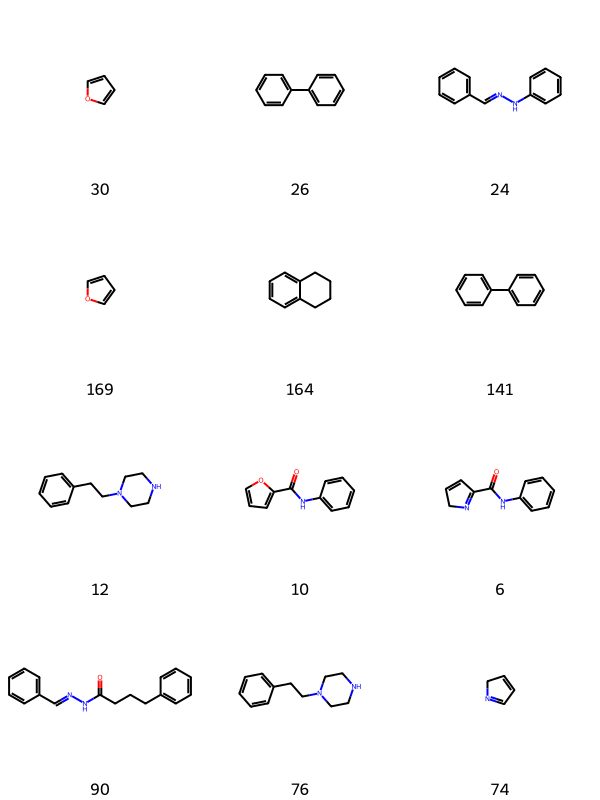

In [22]:
# Top 3 novel scaffolds
num=12
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in list(top_3_unk[i] for i in list(range(num)))],
                     legends=[str(count) for scaffold, count in list(top_3_unk[i] for i in list(range(num)))],
                     subImgSize=(200, 200))

## 3 Prospective validation
### 3.1 Scaffolds present in GRML active in later versions of ChEMBL
From the Venn diagram between actives and inputs it's stated that there are two scaffolds covered by the novel set that are predicted as active. One of them is present only in GRML and the other one is present in GRMl and RML

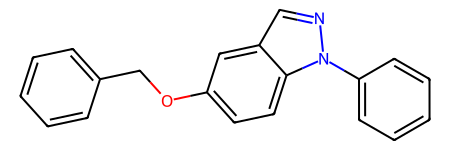

In [23]:
# GRML and ch33
Chem.MolFromSmiles('c1ccc(COc2ccc3c(cnn3-c3ccccc3)c2)cc1')

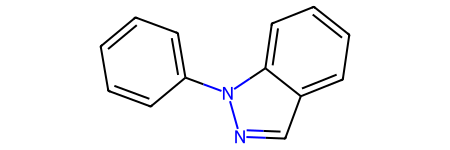

In [24]:
# GRML, RML and ch33
Chem.MolFromSmiles('c1ccc(-n2ncc3ccccc32)cc1')

In [25]:
# get ChEMBL ids with such scaffold
novel_data_smiles = novel_data.canonical_smiles.tolist()
novel_data_ids = novel_data.chembl_id.tolist()

sca1, sca2 = [], []

for i, smi in enumerate(novel_data_smiles):
    scaffold = Chem.MolToSmiles(make_atomic_scaffold(Chem.MolFromSmiles(smi)))
    if scaffold == 'c1ccc(COc2ccc3c(cnn3-c3ccccc3)c2)cc1':
        sca1.append((smi, novel_data_ids[i]))
    elif scaffold == 'c1ccc(-n2ncc3ccccc32)cc1':
        sca2.append((smi, novel_data_ids[i]))

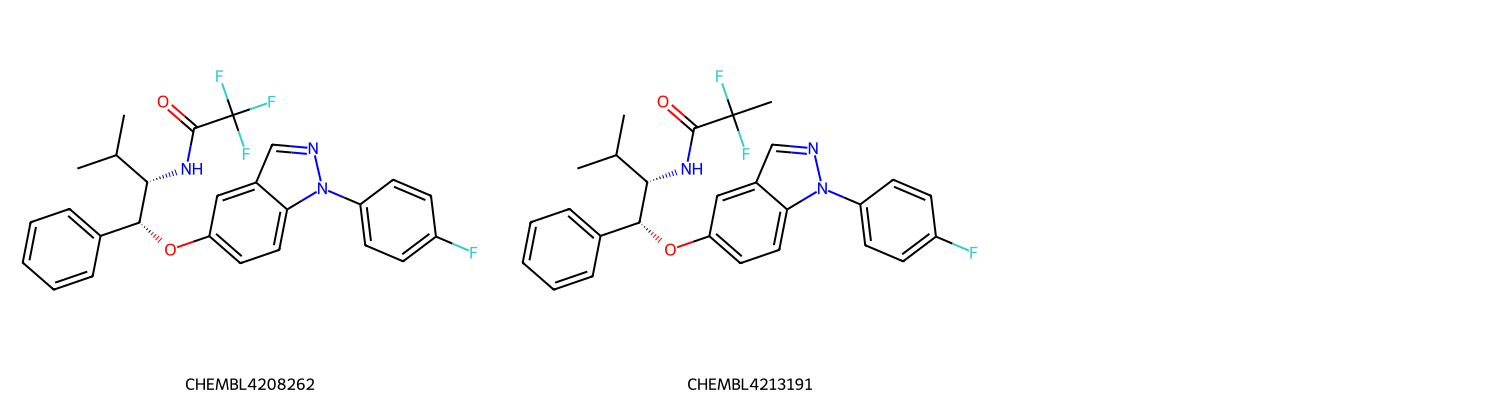

In [26]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in list(sca1[i] for i in list(range(len(sca1))))],
                     legends=[str(count) for scaffold, count in list(sca1[i] for i in list(range(len(sca1))))],
                     subImgSize=(500, 400))

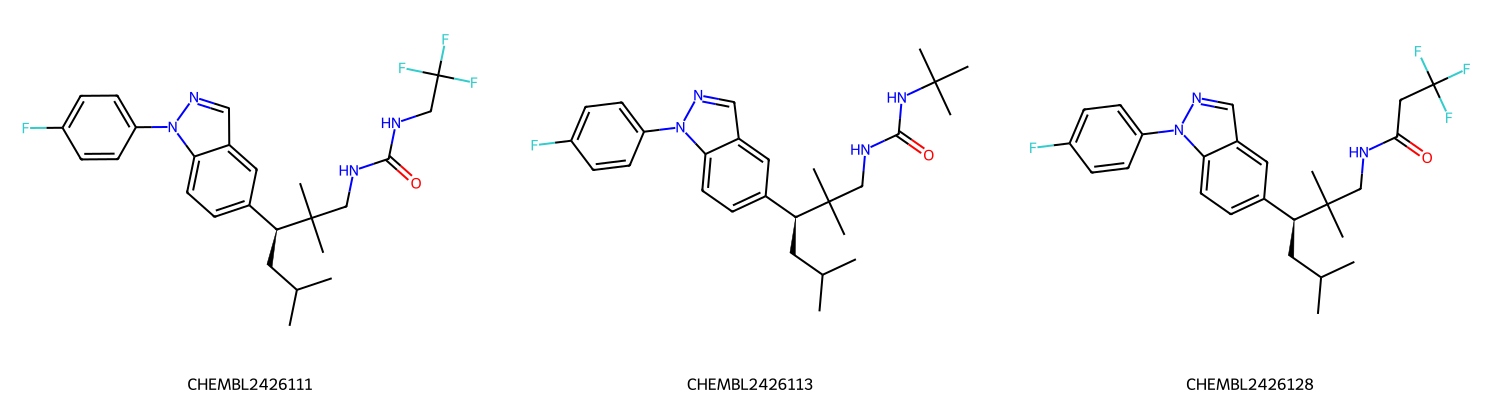

In [27]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in list(sca2[i] for i in list(range(len(sca2))))],
                     legends=[str(count) for scaffold, count in list(sca2[i] for i in list(range(len(sca2))))],
                     subImgSize=(500, 400))

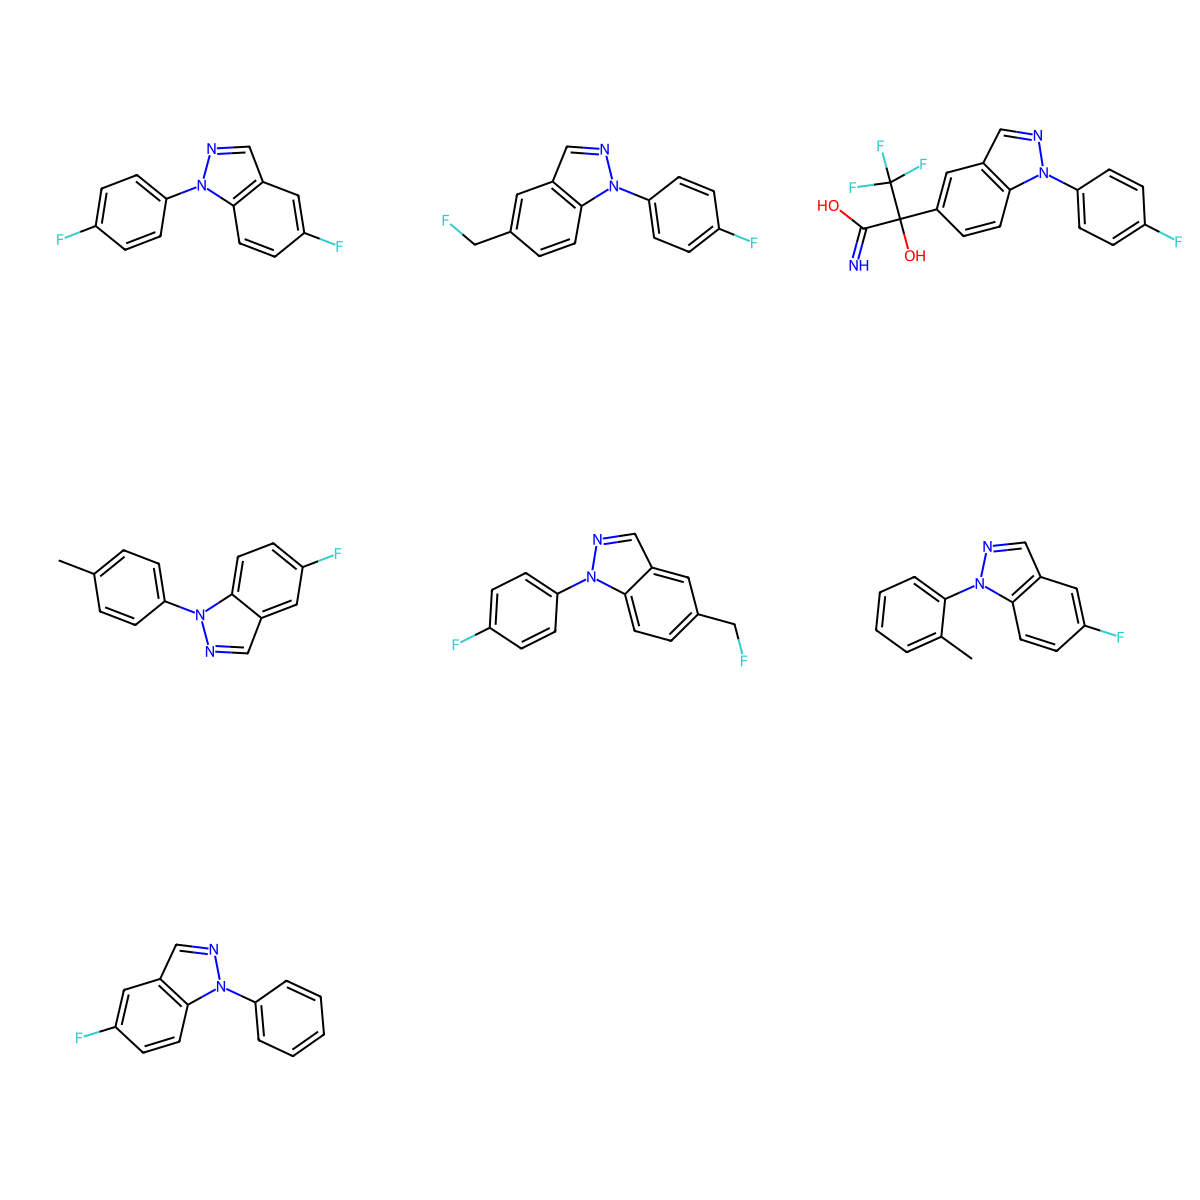

In [28]:
# Morphs that contain 'c1ccc(-n2ncc3ccccc32)cc1'

morphs = []
for smi in GRML_actives_M17.morph_smiles.tolist():
    if Chem.MolToSmiles(make_atomic_scaffold(Chem.MolFromSmiles(smi))) == 'c1ccc(-n2ncc3ccccc32)cc1':
        morphs.append(smi)

Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold in morphs],
                     subImgSize=(400, 400))

## 4 Prioritization of morphs
### 4.1 QED, NIBR Severity score and MolSkill score


In [29]:
# Export active morphs to run NIBR
# TODO move the file to other location anc check if it works
#GRML_active.to_csv('./results/GRML_actives.csv', sep = ',', index = False)
GRML_active = pd.read_csv('./results/GRML_actives.csv', sep = ',')
cmd = f"python ./src/assignSubstructureFilters.py \
    --data {os.getcwd()}/results/GRML_actives.csv --smilesColumn morph_smiles \
        --result {os.getcwd()}/results/GRML_actives_NIBR.csv"
os.system(cmd)
nibr = pd.read_csv('./results/GRML_actives_NIBR.csv', sep = ',')

# Obtain NIBR, QED and MolSkill scores for all the actives morphs - to export to excel file
severity_scores = nibr.SeverityScore.tolist()
smiles = GRML_active.morph_smiles.tolist()
mols = [Chem.MolFromSmiles(s) for s in smiles]
qeds=[QED.qed(m) for m in mols]
scorer = MolSkillScorer()
scores = scorer.score(smiles)

---> Reading data
---> Apply filters to data
---> Done
[2023-10-29 20:47:13,421] [INFO] [scorer.py:52:__init__] Model not specified. Using default from /mnt/storage-plzen1/home/agealorm/miniconda/envs/GRML_analyses/lib/python3.11/site-packages/models/default/checkpoints/last.ckpt.


Lightning automatically upgraded your loaded checkpoint from v1.6.3 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../mnt/storage-plzen1/home/agealorm/miniconda/envs/GRML_analyses/lib/python3.11/site-packages/models/default/checkpoints/last.ckpt`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/storage/plzen1/home/agealorm/miniconda/envs/GRML_analyses/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one 

Predicting: |          | 0/? [00:00<?, ?it/s]

In [30]:
GRML_active['QED'] = qeds
GRML_active['NIBR_Severity_score'] = severity_scores
GRML_active['MolSkill_score'] = scores
GRML_active = GRML_active.sort_values(by = ['QED', 'NIBR_Severity_score', 'MolSkill_score'], ascending = [False, True, True]).reset_index(drop = True)

## 4.2 3D filtering
Pharmacophore:

In [31]:
# TODO Change path and names of files
confs_ph4 = pd.read_csv('./data/GRML_actives_pharmacophore.txt', sep = ',')
confs_ph4_dock_ph4 = pd.read_csv('./data/GRML_actives_docking_pharmacophore.txt', sep = ',')
remaining_morph_ids = GRML_active.loc[(GRML_active['QED'] > 0.4) & \
                                      (GRML_active['NIBR_Severity_score'] < 10) & \
                                        (GRML_active['MolSkill_score'] < 9)].id_morph.tolist()
confs_ph4_1 = confs_ph4.loc[confs_ph4['id_morph'].isin(remaining_morph_ids)]
confs_ph4_dock_ph4_2 = confs_ph4_dock_ph4.loc[confs_ph4_dock_ph4['id_morph'].isin(remaining_morph_ids)]

In [32]:
# Add column for 3D filtering binary results
GRML_active['Pharmacophore'] = GRML_active['id_morph'].apply(lambda x: 1 if x in confs_ph4_1.id_morph.tolist() else 0)
GRML_active['Docking+Pharmacophore'] = GRML_active['id_morph'].apply(lambda x: 1 if x in confs_ph4_dock_ph4_2.id_morph.tolist() else 0)

In [33]:
# Length of rows where QED < 0.4
length_1 = len(GRML_active[GRML_active['QED'] > 0.4])

# Length of rows where QED < 0.4 and NIBR_Severity_score < 10
length_2 = len(GRML_active[(GRML_active['QED'] > 0.4) & (GRML_active['NIBR_Severity_score'] < 10)])

# Length of rows where QED < 0.4, NIBR_Severity_score < 10, and MolSkill_score < 9
length_3 = len(GRML_active[(GRML_active['QED'] > 0.4) & (GRML_active['NIBR_Severity_score'] < 10) & \
                           (GRML_active['MolSkill_score'] < 9)])

# Length of rows where QED < 0.4, NIBR_Severity_score < 10, MolSkill_score < 9, and Pharmacophore == 1
length_4 = len(GRML_active[(GRML_active['QED'] > 0.4) & (GRML_active['NIBR_Severity_score'] < 10) & \
                           (GRML_active['MolSkill_score'] < 9) & (GRML_active['Pharmacophore'] == 1)])

# Length of rows where QED < 0.4, NIBR_Severity_score < 10, MolSkill_score < 9, Pharmacophore == 1, and Docking+Pharmacophore == 1
length_5 = len(GRML_active[(GRML_active['QED'] > 0.4) & (GRML_active['NIBR_Severity_score'] < 10) & \
                           (GRML_active['MolSkill_score'] < 9) & (GRML_active['Pharmacophore'] == 1) & \
                            (GRML_active['Docking+Pharmacophore'] == 1)])

print("Number of rows where QED < 0.4:", length_1)
print("Number of rows where QED < 0.4 and NIBR_Severity_score < 10:", length_2)
print("Number of rows where QED < 0.4, NIBR_Severity_score < 10, and MolSkill_score < 9:", length_3)
print("Number of rows where QED < 0.4, NIBR_Severity_score < 10, MolSkill_score < 9, and Pharmacophore == 1:", length_4)
print("Number of rows where QED < 0.4, NIBR_Severity_score < 10, MolSkill_score < 9, Pharmacophore == 1, \
      and Docking+Pharmacophore == 1:", length_5)

Number of rows where QED < 0.4: 20338
Number of rows where QED < 0.4 and NIBR_Severity_score < 10: 16242
Number of rows where QED < 0.4, NIBR_Severity_score < 10, and MolSkill_score < 9: 10174
Number of rows where QED < 0.4, NIBR_Severity_score < 10, MolSkill_score < 9, and Pharmacophore == 1: 1699
Number of rows where QED < 0.4, NIBR_Severity_score < 10, MolSkill_score < 9, Pharmacophore == 1,       and Docking+Pharmacophore == 1: 54


## 4.3 RFR + manual annotation

In [34]:
# import RFR model
with open('./models/GR_RFR_model.pkl', 'rb') as file:
    RFR_model = pickle.load(file)

# Predict pEC50
final_actives = GRML_active[(GRML_active['QED'] > 0.4) & (GRML_active['NIBR_Severity_score'] < 10) & \
                           (GRML_active['MolSkill_score'] < 9) & (GRML_active['Pharmacophore'] == 1) & \
                            (GRML_active['Docking+Pharmacophore'] == 1)]
GRML_actives_fps = mfp(final_actives, 'morph_smiles')
active_morphs_prediction = RFR_model.predict(GRML_actives_fps)
final_actives['predicted_pEC50'] = active_morphs_prediction


/var/tmp/pbs.18466668.meta-pbs.metacentrum.cz/ipykernel_595825/1390606872.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_actives['predicted_pEC50'] = active_morphs_prediction


In [35]:
# include manual annotations
manually_curated = pd.read_csv('./results/prioritized_morphs_filtered.csv', sep = ',')
manually_curated = manually_curated[['id_morph', 'pass', 'comment']]
manually_curated.columns = ['id_morph', 'manual_filter', 'observation']
final_actives = pd.merge(final_actives, manually_curated, on = 'id_morph')

In [36]:
# export excel with all scores and RFR + manual notation
with pd.ExcelWriter("/storage/plzen1/home/agealorm/RFC-MCCP/GRML_analyses/results/final_morphs_prioritized.xlsx", engine='xlsxwriter') as writer:
    GRML_active.to_excel(writer, sheet_name="all_GRML_actives", index=False)
    final_actives.sort_values(by = 'predicted_pEC50', ascending = False).to_excel(writer, sheet_name="final_GRML_actives", index=False)


In [37]:
with pd.ExcelWriter("/storage/plzen1/home/agealorm/RFC-MCCP/GRML_analyses/results/ML_actives_predicted.xlsx", engine='xlsxwriter') as writer:
    GRML_active.to_excel(writer, sheet_name="all_GRML_actives", index=False)
    RML_active.to_excel(writer, sheet_name="all_RML_actives", index=False)    
    final_actives.sort_values(by = 'predicted_pEC50', ascending = False).to_excel(writer, sheet_name="Proposed_GR_ligands", index=False)

# Visualize final morphs

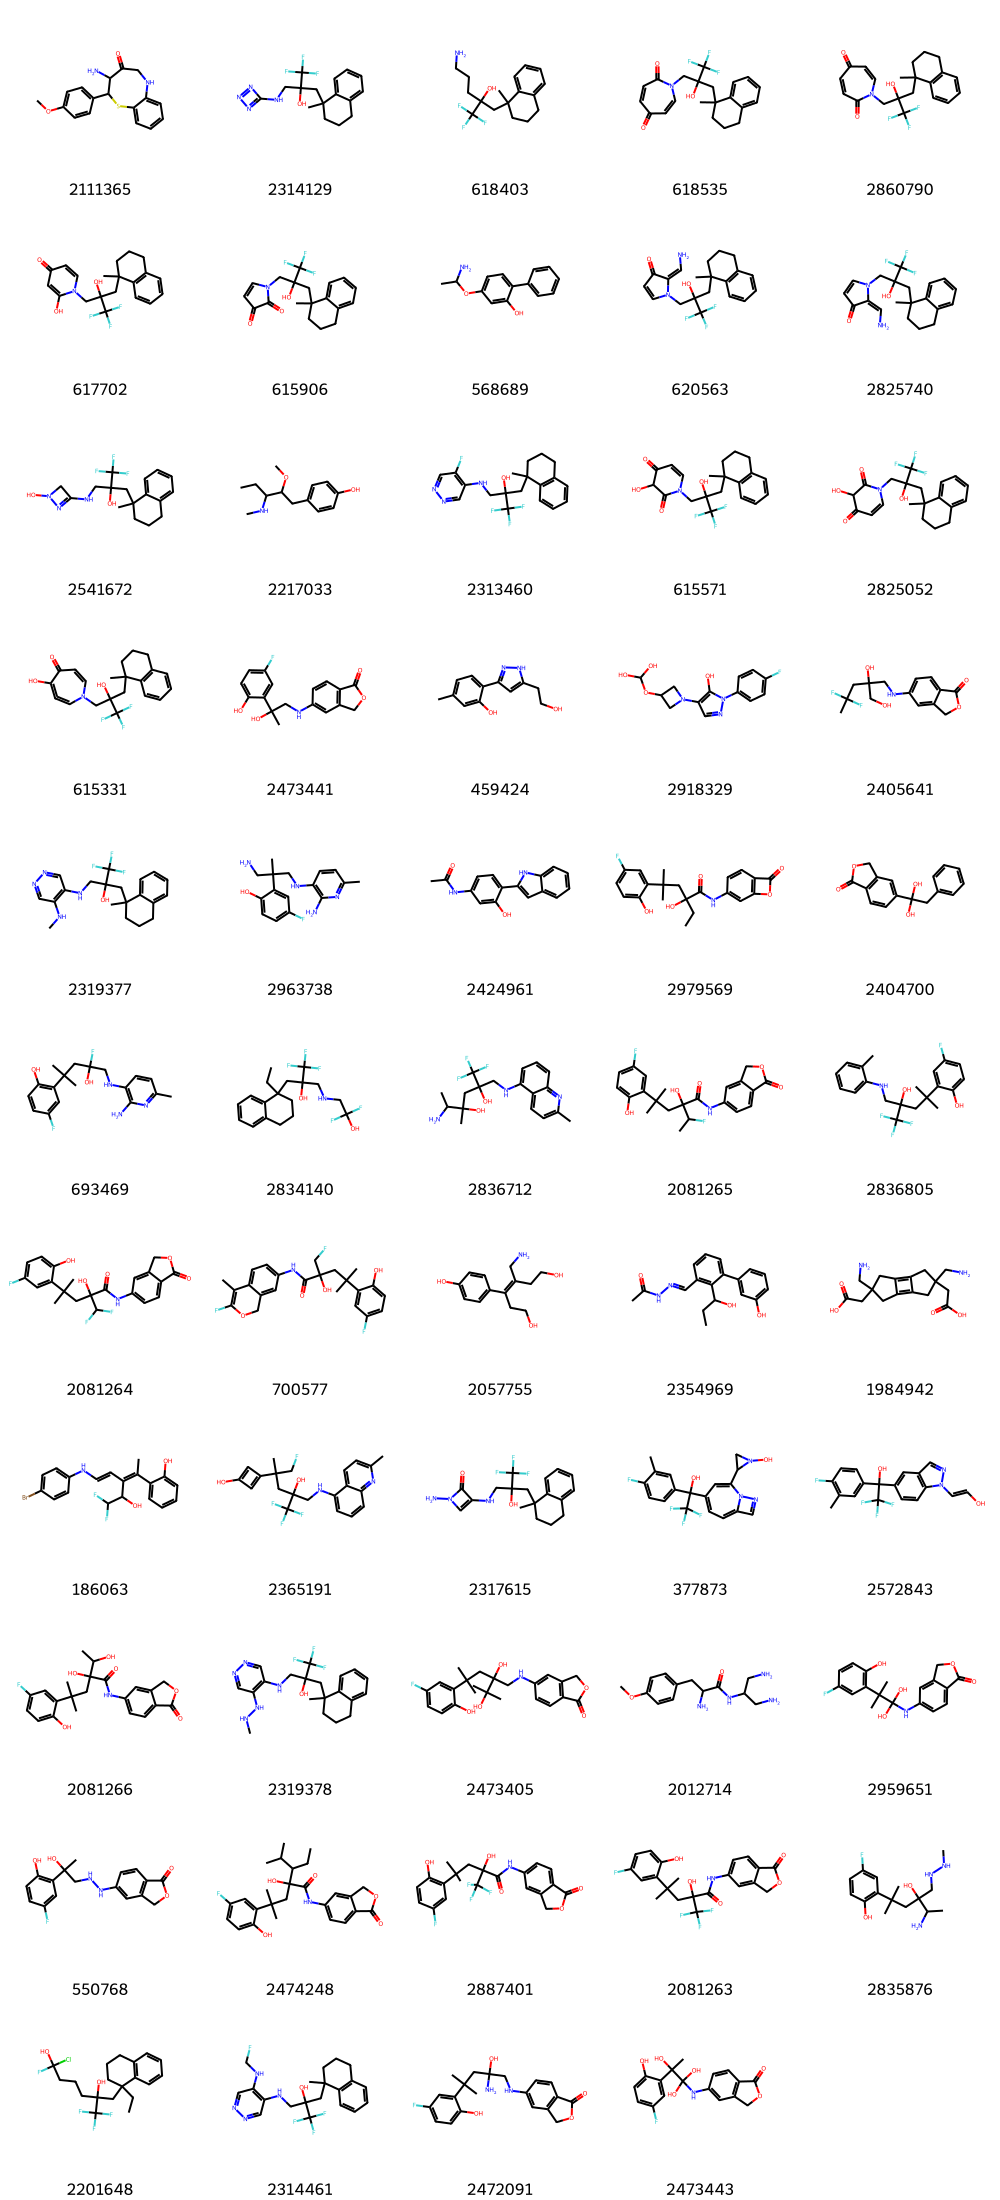

In [38]:
# all of them
mols_final = [Chem.MolFromSmiles(smi) for smi in final_actives.morph_smiles.tolist()]
id_morphs_final = final_actives.id_morph.tolist()
Draw.MolsToGridImage(mols_final,legends=[str(x) for x in id_morphs_final],molsPerRow=5,maxMols=100)

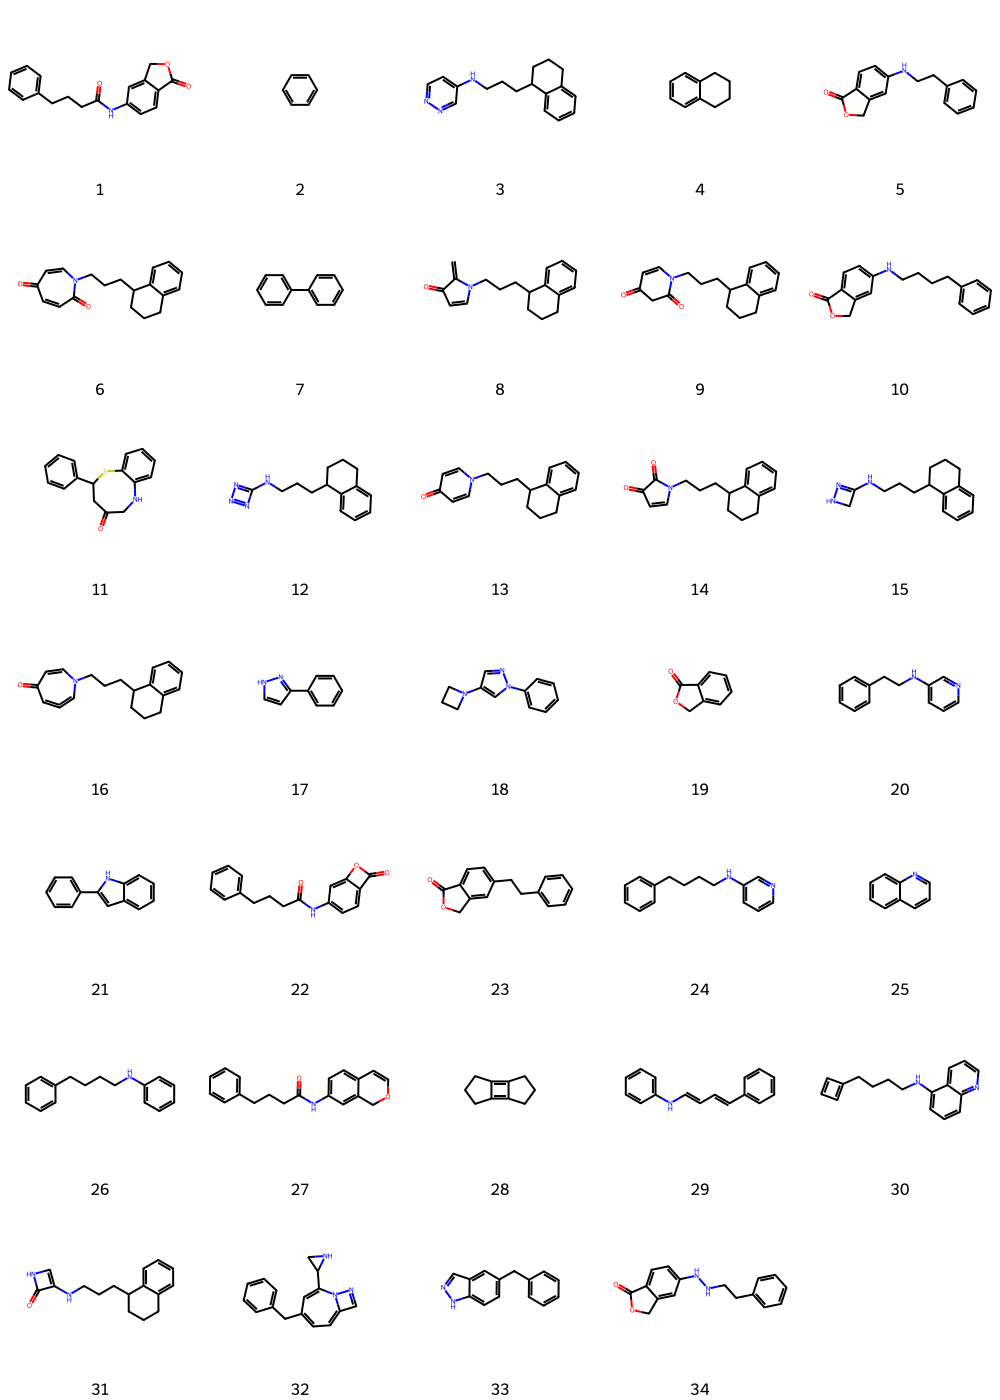

In [39]:
# the different scaffolds
atomic_scaffolds = [Chem.MolToSmiles(make_atomic_scaffold(mol)) for mol in mols_final]
atomic_sca_count = smiles_counts(atomic_scaffolds)
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, _ in list(atomic_sca_count)],
                     legends=[str(count+1) for count in range(len(atomic_sca_count))], molsPerRow=5)

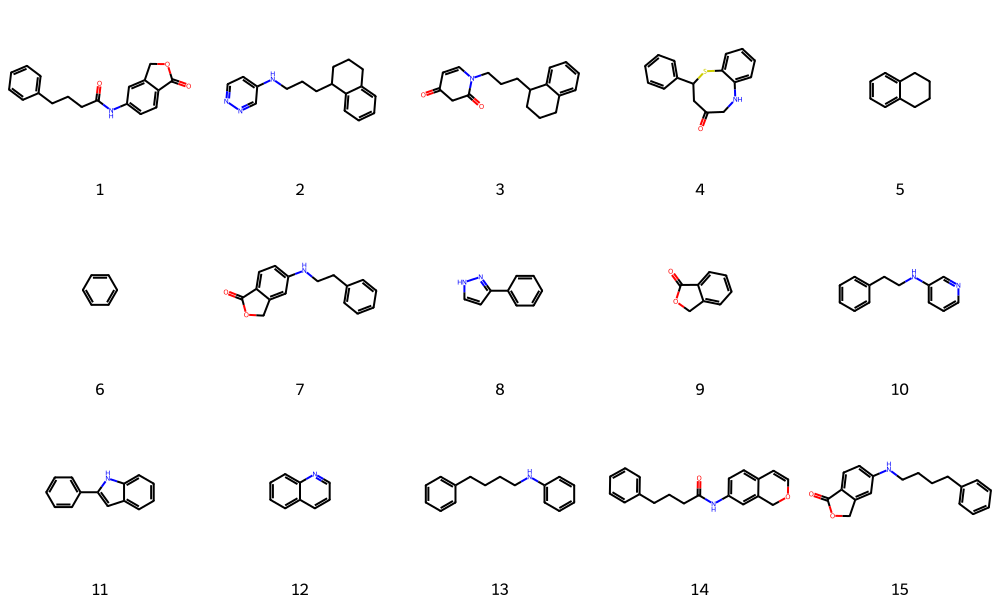

In [40]:
# Those without warnings from the manual curation
final_actives_strict = final_actives.loc[(final_actives['manual_filter'] == 1) & (final_actives['observation'].isna())]
atomic_scaffolds = [Chem.MolToSmiles(make_atomic_scaffold(Chem.MolFromSmiles(smi))) for smi in final_actives_strict.morph_smiles.tolist()]
atomic_sca_count = smiles_counts(atomic_scaffolds)
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, _ in list(atomic_sca_count)],
                     legends=[str(count+1) for count in range(len(atomic_sca_count))], molsPerRow=5)